## Notebook Magic

In [1]:
%matplotlib inline
%load_ext autoreload

## Imports

In [2]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve

from sklearn.linear_model import LogisticRegression, Lasso

In [3]:
df = pd.read_parquet("s3://iefp-unemployment/modelling.parquet")
print(df.shape)

(137888, 99)


In [34]:
df[(df["journey_length"] < 365) & (df["success"] == True)].shape

(40966, 99)

In [35]:
40966/137888

0.2970961940125319

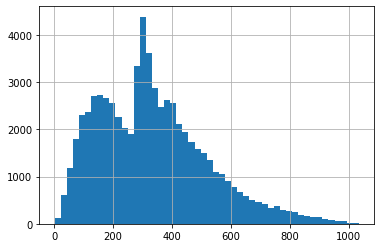

In [5]:
df[df.success == True].journey_length.hist(bins=50)

### Success rates of whole dataset

In [6]:
((df["journey_length"] < 365) & (df["success"] == True)).value_counts() / len(df)

False    0.702904
True     0.297096
dtype: float64

In [7]:
def plot_precision_recall(y_test, y_pred, y_prob):
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    print("{:.2f}% Precision at {}% Recall".format(100 * precision[recall>0.8].max(), 80))

    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()
    
def plot_roc_curve(y_test, y_prob):
    fpr, tpr, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def evaluate(y_test, y_pred, y_prob):
    print(confusion_matrix(y_test, y_pred))
    print("\n---")
    print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))
    print("\n---")
    plot_precision_recall(y_test, y_pred, y_prob)
    plot_roc_curve(y_test, y_prob)

In [8]:
def construct_table(df): 
    # Filter for frequent interventions
    # WARNING: data leakage
    # frequent_i = df_model.mean()[df_model.mean() > 0.01].index.tolist()
    # df_model = df_model[frequent_i]
    
    
    interv_cols = [col for col in df.columns if "i_" in col]
    df_model = transform_interventions(df, interv_cols)
    
    dems = [
    "d_age",
    "d_gender",
    "d_civil_status",
    "d_rsi",
    "d_desired_work_time",
    "d_desired_contract",
    "d_disabled",
    "d_nationality",
    "d_desired_job_sector",
    "d_previous_job_sector",
    ]
    
    df_model[dems] = df[dems]

    # Seasonal features
    df_model["register_month"] = df.register_date.dt.month
    df_model["register_year"] = df.register_date.dt.year

    
    df_model = pd.get_dummies(df_model, drop_first=True, dummy_na=True)

    # Output
    df_model["ttj_sub_12"] = (df["journey_length"] < 365) & (df["success"] == True)
    
    return df_model

def transform_interventions(df: pd.DataFrame, interventions: list):
    df = df[interventions]
    df = (df.notna()).astype('int')
    
    return df

## Get hold out set

In [9]:
df_model = construct_table(df)

In [10]:
df_model["exit_date"] = df["exit_date"]
df_hold_out = df_model[df_model["exit_date"] >= "2019-01-01"].drop("exit_date", axis=1)
print(df_hold_out.shape)
df_hold_out.ttj_sub_12.value_counts() / len(df_hold_out)

(33644, 211)


False    0.758947
True     0.241053
Name: ttj_sub_12, dtype: float64

In [11]:
df_model["exit_date"] = df["exit_date"]
df_train = df_model[df_model["exit_date"] <= "2019-01-01"].drop("exit_date", axis=1)
print(df_train.shape)
df_train.ttj_sub_12.value_counts() / len(df_train)

(104244, 211)


False    0.684816
True     0.315184
Name: ttj_sub_12, dtype: float64

*Training set has more ttj_sub_12 journeys*

# Modelling

## Random Forest

In [12]:
y = df_train["ttj_sub_12"]
X = df_train.drop("ttj_sub_12", axis=1)

In [13]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0, class_weight="balanced")
rf.fit(X, y)
y_pred = rf.predict(X)
y_prob = rf.predict_proba(X)[:,1]

[[41969 29419]
 [10771 22085]]

---
Accuracy: 61.45%

---
39.16% Precision at 80% Recall


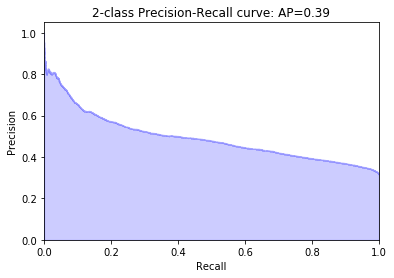

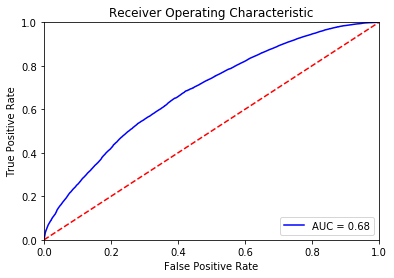

In [14]:
evaluate(y, y_pred, y_prob)

In [15]:
pd.Series(rf.feature_importances_, X.columns).sort_values(ascending=False).head(20)

register_year                             0.173955
i_modular                                 0.108569
i_efa_s3_type_a                           0.076471
i_efa_n3_vocational_train                 0.069040
d_disabled                                0.064459
i_information_job_eval_orientat           0.063689
i_employment_contract_insertion           0.051307
i_employment-insertion_contract           0.045268
d_previous_job_sector_nan                 0.045119
d_age                                     0.044750
register_month                            0.032487
i_tutoring_in_individual_job_search       0.028956
i_efa_contin_train_type_b3                0.027036
i_train_active_life                       0.026827
i_efa_n2_vocational_train                 0.015333
i_tutoring_in_collective_job_search       0.012750
i_efa_contin_train_type_b2                0.010416
d_desired_job_sector_Unskilled workers    0.009057
i_technological_expertise                 0.007683
i_internship_job               

### Cross-Val

In [16]:
scoring = ['precision_macro', 'average_precision', 'accuracy', 'roc_auc']
scores = cross_validate(rf, X, y, scoring=scoring, cv=5)

In [17]:
pd.DataFrame(scores).mean()

fit_time                  17.736979
score_time                 3.828998
test_precision_macro       0.605229
test_average_precision     0.485278
test_accuracy              0.618540
test_roc_auc               0.676396
dtype: float64

### Test on hold-out

In [18]:
# Train on whole training set
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [19]:
y_hold = df_hold_out["ttj_sub_12"]
X_hold = df_hold_out.drop("ttj_sub_12", axis=1)
y_hold.value_counts() / len(y_hold)

False    0.758947
True     0.241053
Name: ttj_sub_12, dtype: float64

In [20]:
y_pred = rf.predict(X_hold)
y_prob = rf.predict_proba(X_hold)[:,1]

[[10989 14545]
 [  117  7993]]

---
Accuracy: 56.42%

---
50.49% Precision at 80% Recall


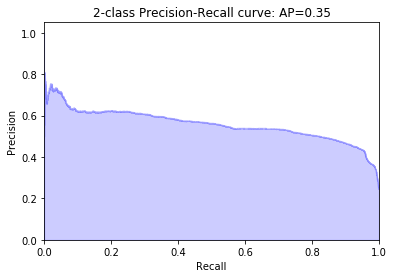

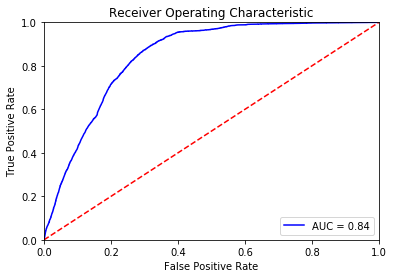

In [21]:
evaluate(y_hold, y_pred, y_prob)

## Regression

In [23]:
lg = LogisticRegression(random_state=0, penalty='l2', solver='liblinear')
lg.fit(X, y)
y_pred = lg.predict(X)
y_prob = lg.predict_proba(X)[:,1]

In [ ]:
evaluate(y_test, y_pred, y_prob)

In [24]:
feats = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lg.coef_))], axis = 1)
feats.columns = ["Feature", "Coefficient"]
feats.sort_values("Coefficient", ascending=False)

,Feature,Coefficient
5,i_tutoring_in_individual_job_search,0.479907
30,i_tutoring_in_collective_job_search,0.387942
15,i_professional_internships,0.353978
16,i_internship_job,0.245736
54,i_assertive_communication_job_search_techn,0.221838
20,i_employment-insertion_contract,0.191974
29,i_collective_orientation_session,0.162203
66,d_gender_M,0.153971
205,d_previous_job_sector_Machinery_Operators_Tran...,0.138423
201,d_previous_job_sector_Agriculture,0.134223
